In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt

In [2]:
dev = qml.device('default.qubit', wires = 2)

In [3]:
@qml.qnode(dev)
def circuit(params):
    A = np.array([[ 0.5, 0.5],
           [ 0.5,  0.5]])
    qml.U3(params[0], params[1], params[2], wires = 0)
    
    return qml.expval(qml.Hermitian(A, wires = 0))

In [4]:
params = [np.pi*0.5, 0, 0.3]
a = circuit(params)
a

0.9999999999999996

In [5]:
def cost(x):
    
    return (1.0 - circuit(x))

In [6]:
init_params = np.array([0.7, 0, 0.3])
cost(init_params)

0.17789115638115482

In [7]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [8]:
for i in range(steps):
    
    params = opt.step(cost, params)
    
print(params)

[1.57079633 0.         0.3       ]


In [9]:
cost(params)

4.440892098500626e-16

## Generating a proper random quantum state and its probability vector

Explain some things here
$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

$|v| = \sqrt{\langle v| v \rangle} = \sqrt{v^{\dagger}v}$

In [10]:
def norm(complex_vector: np.array) -> float:
    """Returns the norm of a complex vector.
    
    Args:
       complex_vector (np.arrray of shape (dim,)):
           complex vector with an arbitrary dimension.
           
       
    Returns:
        norm (float): norm or magnitude of the complex vector.
            
    """
    
    #define the norm of a complex vector here
    norm = np.sqrt(sum([np.square(np.absolute(complex_vector[i])) for i in range(complex_vector.shape[0])]))
    
    return norm

def random_quantum_state(dim: int) -> np.array:
    """Creates a normalized random complex vector of a defined
    dimension.
    
    Args:
        dim (int): integer number specifying the dimension
            of the vector that we want to generate.
            
    Returns:
        (np.array): normalized complex vector of the given
            dimension.
    """
    #generate an unnormalized complex vector of dimension = dim
    Z = np.random.random(dim) + np.random.random(dim)*1j
    
    #normalize the complex vector Z
    Z /= norm(Z)
    
    return Z

def get_probabilities(complex_vector: np.array) -> np.array:
    """Get the probabilities associated to a quantum state.
    This is a vector in which each element is the square of
    the magnitude of respective complex number in that element.
    
    Args:
        complex_vector (np.array):
        
    Retuns:
        (np.array): 
    """
    
    if 1.0 - norm(complex_vector) > 0.001:
        print("Alert! The quantum state apparently is not normalized.")
        
    else:
        return np.square(np.absolute(complex_vector))

In [11]:
#two qubits -> a complex vector of dimension 4
n_qubits = 3
dim = 2**(n_qubits)
psi = random_quantum_state(dim)

In [12]:
get_probabilities(psi)

tensor([0.13276957, 0.07809907, 0.08228659, 0.0585683 , 0.2111603 ,
        0.18551846, 0.01017784, 0.24141987], requires_grad=True)

## Building the variational quantum circuit in Qiskit

In [13]:
def build_variational_circuit(number_layers: int, params: np.array) -> QuantumCircuit:
    #how many parameters will have given the number_layers
    n_parameters = 8*number_layers
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a circuit of {n_parameters} parameters.")
        
    else:
        #create the circuit
        qr = QuantumRegister(4, name="q")
        cr = ClassicalRegister(4, name="c")
        qc = QuantumCircuit(qr, cr)

        #number of parameters per layer
        n_parameters_per_layer = 8
        for i in range(number_layers):
            start = i*n_parameters_per_layer
            end = (i+1)*n_parameters_per_layer 
            layer(qc, params[start:end])
            
        return qc
    
def layer(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(qc, params[:int(n_parameters/2)])
        even_block(qc, params[int(n_parameters/2):])
        qc.barrier()
        
#qiskit  odd block
def odd_block(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rx(params[i], i)
        
#qiskit even block
def even_block(qc: QuantumCircuit, params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qc.rz(params[i], i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qc.cz(tup[0], tup[1])

In [14]:
n_parameters_per_layer = 8
n_layers = 2
params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
qc = build_variational_circuit(n_layers, params)

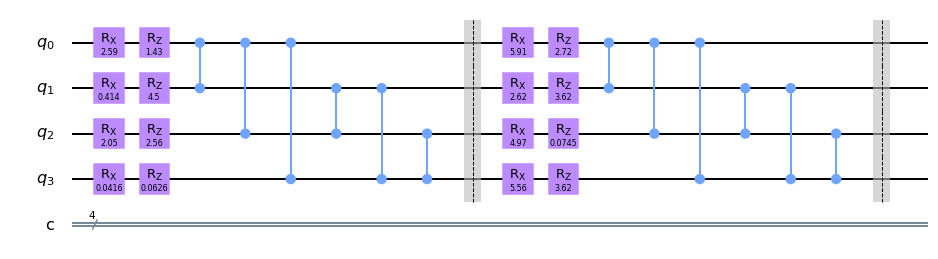

In [15]:
qc.draw(output='mpl')

## Optimization

In [16]:
backend = Aer.get_backend('statevector_simulator')

job = execute(qc, backend)

result = job.result()

outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

[-0.04139887-0.09906916j  0.15582585-0.17790073j  0.1858667 +0.0370448j
 -0.29537277-0.66323979j -0.05880619-0.04529795j  0.02657815+0.15272407j
 -0.18063365+0.01950777j -0.1771886 +0.39216392j -0.04025377-0.00583108j
  0.0286566 +0.0854889j  -0.04916096+0.05242714j -0.27290961-0.01856221j
  0.02637661-0.01037806j  0.05331677+0.01991508j -0.02797612+0.06512998j
 -0.10521606-0.10881386j]


In [17]:
def norm_vector_difference(params):
    
    qc = build_variational_circuit(n_layers, params)
    
    job = execute(qc, backend)
    
    result = job.result()

    outputstate = result.get_statevector(qc, decimals=3)
    
    diff = outputstate - target_vector
    
    
    return norm(diff)

def get_probability_distribution(counts):
    output_distr = [v / NUM_SHOTS for v in counts.values()]
    if len(output_distr) == 1:
        output_distr.append(0)
    output_distr = np.asarray(output_distr)
    
    return output_distr

def probability_difference(params):
    # Obtain a quantum circuit instance from the paramters
    qc = build_variational_circuit(n_layers, params)
    # Measure all qubits
    qc.measure_all()
    # Execute the quantum circuit to obtain the probability distribution associated with the current parameters
    result = execute(qc, backend, shots=NUM_SHOTS).result()
    # Obtain the counts for each measured state, and convert those counts into a probability vector
    output_distr = get_probability_distribution(result.get_counts(qc))
    # Calculate the cost as the distance between the output distribution and the target distribution
    cost = sum([np.absolute(output_distr[i] - target_distr[i]) for i in range(output_distr.shape[0])])
    return cost

In [18]:
n_qubits = 4
dim = n_qubits**2
target_vector = random_quantum_state(dim)
target_distr = get_probabilities(target_vector)

In [19]:
# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
cost_list = []
for n_layers in range(1,11):
    n_parameters_per_layer = 8
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=norm_vector_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    final_vector = execute(qc, backend).result().get_statevector(qc, decimals = 3)
    
    #save cost function values
    cost_list.append(ret[1])
    
    print("Number of layers:", n_layers)
    print("Target Vector:", target_vector)
    print("Obtained Vector:", final_vector)
    print("Norm difference:", ret[1])
    print("Parameters Found:", ret[0])
    print('')

Number of layers: 1
Target Vector: [0.12782348+0.25120257j 0.20268652+0.17524096j 0.24583628+0.17861963j
 0.21118092+0.06194898j 0.2530496 +0.09419125j 0.00203256+0.04430726j
 0.19264602+0.28354154j 0.2291919 +0.12188836j 0.02939776+0.17906887j
 0.16088031+0.21692192j 0.12899148+0.26295999j 0.08109078+0.17768977j
 0.1400312 +0.26061912j 0.16753044+0.06893906j 0.05878861+0.21435471j
 0.18946869+0.11299651j]
Obtained Vector: [-0.2488955 +0.j          0.04843528+0.15366678j  0.22469791+0.19671856j
 -0.0777266 +0.17700892j  0.27492225+0.21749203j -0.08077833+0.2120597j
  0.07629602+0.41363672j  0.24052987-0.12759883j  0.09391229+0.16137441j
 -0.0813563 +0.08938456j -0.04276271+0.21991071j  0.14409338-0.01639334j
 -0.03728099+0.26031243j  0.16797045-0.02763994j  0.23939866-0.20553927j
  0.17348605+0.10780536j]
Norm difference: 0.9341652429447447
Parameters Found: [5.13418289 1.75201041 4.37642443 4.99597754 2.83625278 5.43149087
 2.24008916 2.61454886]

Number of layers: 2
Target Vector: [0

Number of layers: 8
Target Vector: [0.12782348+0.25120257j 0.20268652+0.17524096j 0.24583628+0.17861963j
 0.21118092+0.06194898j 0.2530496 +0.09419125j 0.00203256+0.04430726j
 0.19264602+0.28354154j 0.2291919 +0.12188836j 0.02939776+0.17906887j
 0.16088031+0.21692192j 0.12899148+0.26295999j 0.08109078+0.17768977j
 0.1400312 +0.26061912j 0.16753044+0.06893906j 0.05878861+0.21435471j
 0.18946869+0.11299651j]
Obtained Vector: [ 0.12794234+0.24718204j  0.21403773+0.16532466j  0.18254809+0.11735076j
  0.14429706+0.06272174j  0.24054387+0.11888537j -0.01678298+0.14673172j
  0.1558375 +0.30886337j  0.23782582+0.09524304j -0.01112596+0.25164119j
  0.16420128+0.25739004j  0.13330222+0.29556346j  0.08266743+0.12131058j
  0.12234413+0.25054476j  0.14751746+0.02019399j  0.06868468+0.2070236j
  0.2349214 +0.1113776j ]
Norm difference: 0.2123668896226647
Parameters Found: [3.79493142 6.10712229 3.88345843 3.47887639 3.82619841 2.50590911
 3.93817771 4.71191319 3.60576371 5.5288144  2.75621089 3.6127

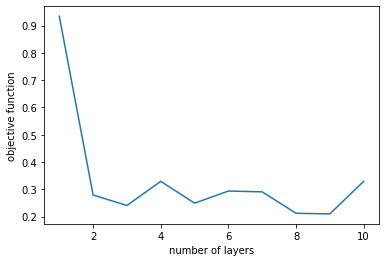

In [20]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

In [21]:
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 10000

# Initialize the COBYLA optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)

# Create the initial parameters (noting that our single qubit variational form has 3 parameters)
n_parameters_per_layer = 8
cost_list = []
for n_layers in range(1,11):
    params = np.random.rand(n_layers*n_parameters_per_layer)*2*np.pi
    ret = optimizer.optimize(num_vars=n_layers*n_parameters_per_layer, objective_function=probability_difference, 
                             initial_point=params)

    # Obtain the output distribution using the final parameters
    qc = build_variational_circuit(n_layers, ret[0])
    qc.measure_all()
    counts = execute(qc, backend, shots=NUM_SHOTS).result().get_counts(qc)
    output_distr = get_probability_distribution(counts)
    
    cost_list.append(ret[1])
    
    print("Number of layers:", n_layers)
    print("Target Distribution:", target_distr)
    print("Obtained Distribution:", output_distr)
    print("Output Error (Manhattan Distance):", ret[1])
    print("Parameters Found:", ret[0])
    print('')

Number of layers: 1
Target Distribution: [0.07944158 0.07179122 0.09234045 0.04843506 0.07290609 0.00196726
 0.11750829 0.0673857  0.03292989 0.07293759 0.08578676 0.03814937
 0.08753106 0.03281904 0.04940404 0.0486666 ]
Obtained Distribution: [0.0757 0.0392 0.0921 0.0494 0.0855 0.0425 0.1032 0.0556 0.0647 0.0344
 0.0787 0.0394 0.0719 0.0368 0.088  0.0429]
Output Error (Manhattan Distance): 0.26349759952109014
Parameters Found: [5.02999964 4.60006946 1.61238871 1.48104415 5.44243958 5.11952382
 4.2520617  4.90996758]

Number of layers: 2
Target Distribution: [0.07944158 0.07179122 0.09234045 0.04843506 0.07290609 0.00196726
 0.11750829 0.0673857  0.03292989 0.07293759 0.08578676 0.03814937
 0.08753106 0.03281904 0.04940404 0.0486666 ]
Obtained Distribution: [0.0456 0.0846 0.0961 0.1119 0.0939 0.0196 0.1002 0.0657 0.025  0.0674
 0.045  0.093  0.0451 0.0155 0.0454 0.046 ]
Output Error (Manhattan Distance): 0.3381019979596539
Parameters Found: [1.53637825 7.64105539 3.64436327 0.13764081 

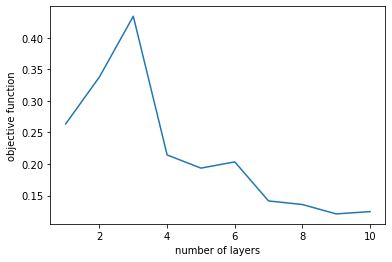

In [22]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("objective function")
plt.show()

## Optimize the variational circuit using Pennylane

In [23]:
dev = qml.device('default.qubit', wires = 4)

In [24]:
target_vector = target_vector.reshape((16,1))
density_matrix = target_vector @ np.transpose(np.conjugate(target_vector))
print(density_matrix.shape)

(16, 16)


In [25]:
def layer(params: np.array) -> None:
    
    n_parameters = 8
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a layer of {n_parameters} parameters.")
        
    else:
        odd_block(params[:int(n_parameters/2)])
        even_block(params[int(n_parameters/2):])

def odd_block(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RX(params[i], wires = i)
        

def even_block(params: np.array) -> None:
    
    n_parameters = 4
    
    if params.shape[0] != n_parameters:
        print(f"Alert! You gave {params.shape[0]} parameters for a block of {n_parameters} parameters.")
        
    else:
    
        for i in range(n_parameters):
            qml.RZ(params[i], wires = i)

        tuples = [(i,j) for i in range(n_parameters) for j in range(n_parameters) if i < j]

        for tup in tuples:
            qml.CZ(wires=[tup[0], tup[1]])

In [26]:
@qml.qnode(dev)
def var_circuit(params):

    #number of parameters per layer
    n_parameters_per_layer = 8
    for i in range(number_layers):
        start = i*n_parameters_per_layer
        end = (i+1)*n_parameters_per_layer 
        layer(params[start:end])

    return qml.expval(qml.Hermitian(density_matrix, wires=[0,1,2,3]))

In [27]:
def cost(x):
    
    return (1.0 - var_circuit(x))

In [28]:
n_parameters_per_layer = 8
number_layers = 1
params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

cost(params)

0.9792106547222991

In [29]:
init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi

In [30]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [31]:
cost_list = []
for number_layers in range(1,11):
    init_params = np.random.rand(number_layers*n_parameters_per_layer)*2*np.pi
    opt = qml.GradientDescentOptimizer(stepsize = 0.4)

    steps = 100

    params = init_params
    for i in range(steps):

        params = opt.step(cost, params)

    print(cost(params))
    cost_list.append(cost(params))

0.4893684312493838
0.06526901345006064
0.06656404109604919
0.023288474996209896
0.0032286632716920227
0.0014189487496305553
0.0005619622372406985
2.4057695421353387e-06
8.076078540364406e-07
4.7126205049430325e-08


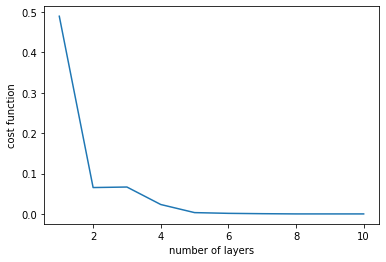

In [32]:
n_layers = range(1,11)
plt.plot(n_layers, cost_list)
plt.xlabel("number of layers")
plt.ylabel("cost function")
plt.show()